# DSC 180B CNN Notebook

### Importing Needed Libraries

In [1]:
!pip uninstall opencv-python-headless -y 
!pip uninstall opencv-python -y
!pip uninstall opencv-contrib-python -y
!pip install opencv-python-headless

  Using cached opencv_python_headless-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (50.0 MB)


In [2]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import torch
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
from torchvision import models
import torch.nn as nn
from tqdm import tqdm
import torchvision.transforms as transforms
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from PIL import Image

import boto3
from botocore.exceptions import NoCredentialsError, PartialCredentialsError

2025-03-02 06:47:34.470351: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-02 06:47:34.528332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-02 06:47:34.547715: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-02 06:47:34.556170: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-02 06:47:34.805623: I tensorflow/core/platform/cpu_feature_guar

### Specify Data Transformations

In [3]:
def preprocess_img(img, img_size=256, crop_size=224, is_train=True):
    # Resize and crop
    img = tf.image.resize(img, (img_size, img_size))
    img = tf.image.central_crop(img, crop_size / img_size)

    if is_train:
        # Random horizontal flip
        img = tf.image.random_flip_left_right(img)
    
        # Random brightness and contrast
        img = tf.image.random_brightness(img, max_delta=0.25)
        img = tf.image.random_contrast(img, lower=0.75, upper=1.25)
    
        # Random affine transformation (rotation & translation)
        def random_affine(img):
            transform = transforms.RandomAffine(
                degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)
            )
            img = img.numpy().astype(np.uint8)  # Ensure the image is in uint8 format
            img_pil = Image.fromarray(img)
            img_pil = transform(img_pil)  # Apply affine transform
            img = np.array(img_pil).astype(np.float32)  # Convert back to float32
            return img
        
        img = random_affine(img)
        
    img = preprocess_input(img)
    
    return img

In [20]:
# Paths for storing images
local_raw_download_path = '../../data/raw/'
local_processed_download_path = '../../data/processed/'
os.makedirs(os.path.join(local_raw_download_path, 'train'), exist_ok=True)
os.makedirs(os.path.join(local_raw_download_path, 'val'), exist_ok=True)
os.makedirs(os.path.join(local_raw_download_path, 'test'), exist_ok=True)

os.makedirs(local_processed_download_path, exist_ok=True)
os.makedirs(os.path.join(local_processed_download_path, 'train'), exist_ok=True)
os.makedirs(os.path.join(local_processed_download_path, 'val'), exist_ok=True)
os.makedirs(os.path.join(local_processed_download_path, 'test'), exist_ok=True)

In [22]:
import boto3
from botocore.exceptions import NoCredentialsError, PartialCredentialsError
import os
import tensorflow as tf
import cv2

# Specify your S3 bucket name
bucket_name = "sagemaker-capstone-bucket"

# Initialize S3 client
s3 = boto3.client("s3")
train_df = {'filename': [], 'label': []}
val_df = {'filename': [], 'label': []}
test_df = {'filename': [], 'label': []}

def extract_label_from_filename(filename):
    """Extracts label from filename based on known keywords."""
    if "bacteria" in filename:
        return "bacteria"
    elif "virus" in filename:
        return "virus"
    else:
        return "normal"

try:
    print(f"Connecting to bucket: {bucket_name}")

    # Use a continuation token for pagination
    continuation_token = None

    for folder_prefix, dataset in zip(["/train", "/val", "test/"], [train_df, val_df, test_df]):
        while True:
            # List objects with pagination
            list_params = {"Bucket": bucket_name, "Prefix": folder_prefix}
            if continuation_token:
                list_params["ContinuationToken"] = continuation_token
    
            response = s3.list_objects_v2(**list_params)
    
            if "Contents" in response:
                for obj in response["Contents"]:
                    key = obj["Key"]
    
                    # Collect .jpg image paths that are not masks
                    if key.endswith(".jpeg"):
                        filename = key.split('/')[-1]
                        label = extract_label_from_filename(key)
                        dataset['filename'].append(filename)
                        dataset['label'].append(label)

                        # Define local paths for raw and processed data
                        raw_local_folder = os.path.join("../../data/raw", folder_prefix)
                        processed_local_folder = os.path.join("../../data/processed", folder_prefix)

                        # Create the directories if they don't exist
                        os.makedirs(raw_local_folder, exist_ok=True)
                        os.makedirs(processed_local_folder, exist_ok=True)
                        
                        # Construct the full path for the raw file to download
                        raw_local_file_path = os.path.join(raw_local_folder, filename)
                        try:
                            s3.download_file(bucket_name, key, raw_local_file_path)
                        except Exception as e:
                            print(f"Error downloading {key}: {e}")
                            continue

                        # Load and process the image
                        img = tf.io.read_file(raw_local_file_path)
                        img = tf.image.decode_jpeg(img, channels=3)
                        if img is None:
                            print(f"Failed to load image: {raw_local_file_path}")
                            continue

                        is_train = (folder_prefix == "train/")  # Simplified flag assignment
                            
                        img = preprocess_img(img, 256, 224, is_train)
                
                        img = img.numpy() if isinstance(img, tf.Tensor) else img
                
                        # Save processed image
                        processed_image_path = os.path.join(processed_local_folder, filename)
                        cv2.imwrite(processed_image_path, img)
                        
            # Check if there's another page of results
            if response.get("IsTruncated"):
                continuation_token = response["NextContinuationToken"]
            else:
                break  # No more objects to fetch

    print("Completed fetching all objects.")
    print(f"Train: {len(train_df['filename'])} images")
    print(f"Validation: {len(val_df['filename'])} images")
    print(f"Test: {len(test_df['filename'])} images")

except NoCredentialsError:
    print("Error: No AWS credentials found.")
except PartialCredentialsError:
    print("Error: Incomplete AWS credentials configuration.")
except s3.exceptions.NoSuchBucket:
    print(f"Error: Bucket {bucket_name} does not exist.")
except Exception as e:
    print(f"Error: {e}")

Connecting to bucket: sagemaker-capstone-bucket


100%|██████████| 625/625 [00:56<00:00, 11.08it/s]

Completed fetching all objects.
Train: 5216 images
Validation: 16 images
Test: 624 images


In [36]:
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_df = pd.DataFrame(train_df)
val_df = pd.DataFrame(val_df)
test_df = pd.DataFrame(test_df)

train_df.head()

In [26]:
##### Converting to binary labels (Subject to change)

train_df['binary_label'] = train_df['label'].apply(lambda x: '0' if x == 'normal' else '1')
val_df['binary_label'] = val_df['label'].apply(lambda x: '0' if x == 'normal' else '1')
test_df['binary_label'] = test_df['label'].apply(lambda x: '0' if x == 'normal' else '1')

In [38]:
# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    train_df, directory='../../data/processed/train', x_col='filename', y_col='binary_label', target_size=(224, 224), batch_size=16, class_mode='binary', validate_filenames=False)

val_generator = val_datagen.flow_from_dataframe(
    val_df, directory='../../data/processed/val', x_col='filename', y_col='binary_label', target_size=(224, 224), batch_size=16, class_mode='binary', validate_filenames=False)

test_generator = test_datagen.flow_from_dataframe(
    test_df, directory='../../data/processed/test', x_col='filename', y_col='binary_label', target_size=(224, 224), batch_size=16, class_mode='binary', validate_filenames=False)

Found 5216 non-validated image filenames belonging to 2 classes.
Found 16 non-validated image filenames belonging to 2 classes.
Found 624 non-validated image filenames belonging to 2 classes.


### Healthy vs Unhealthy Lung Comparison

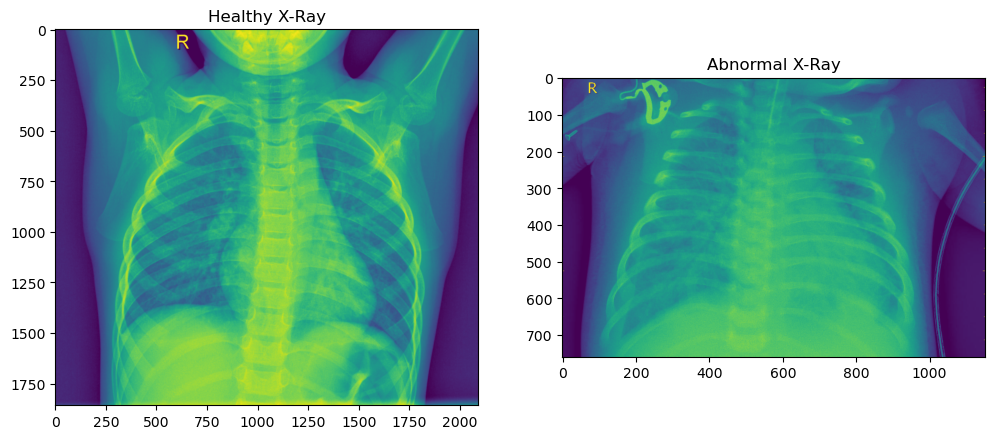

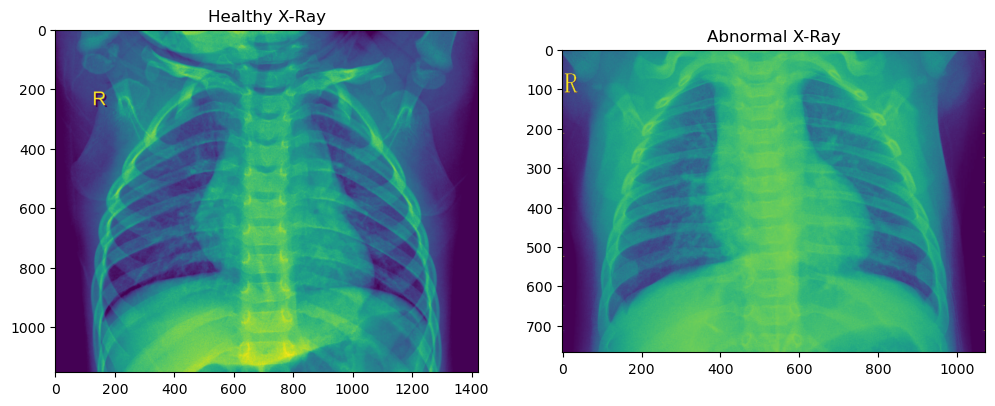

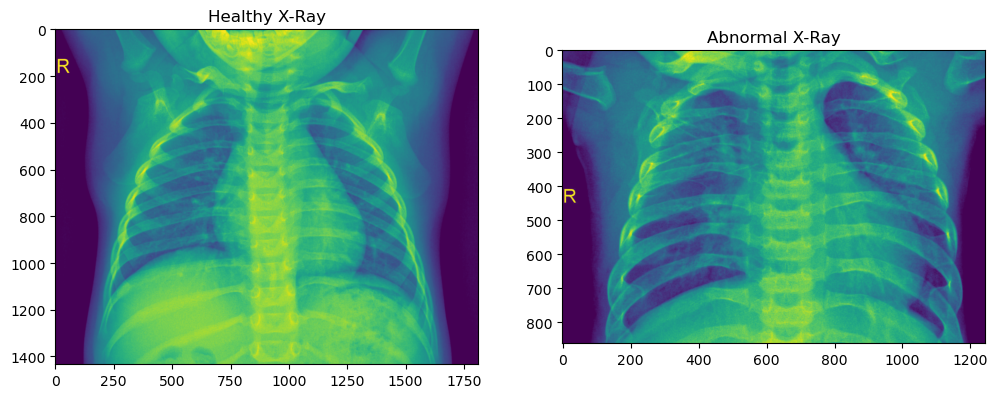

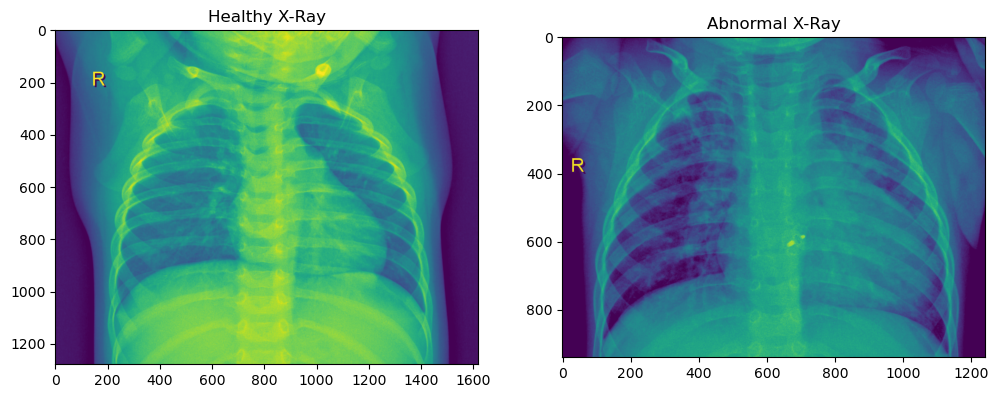

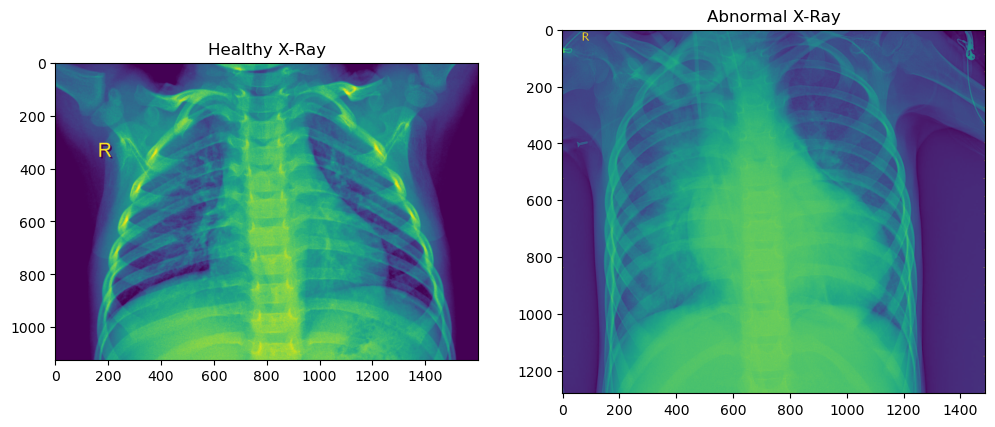

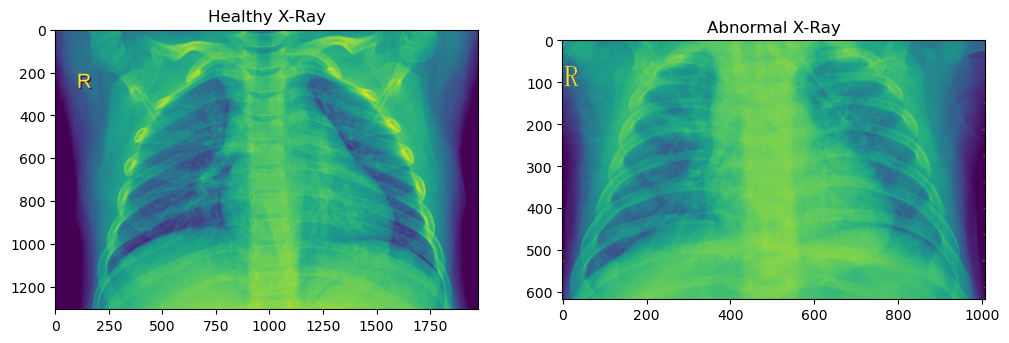

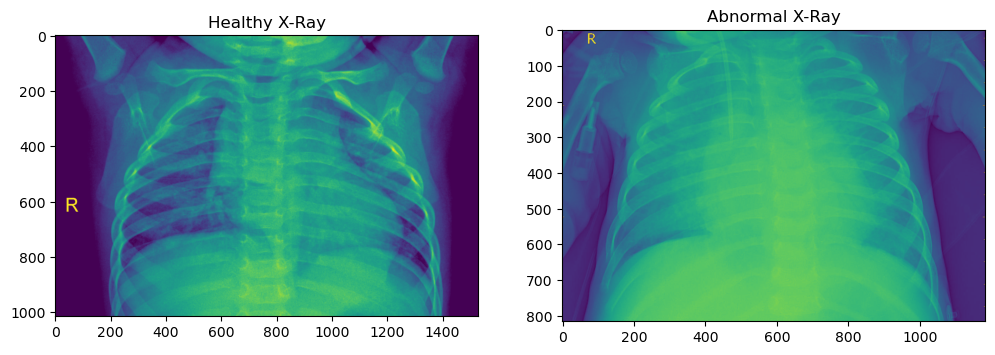

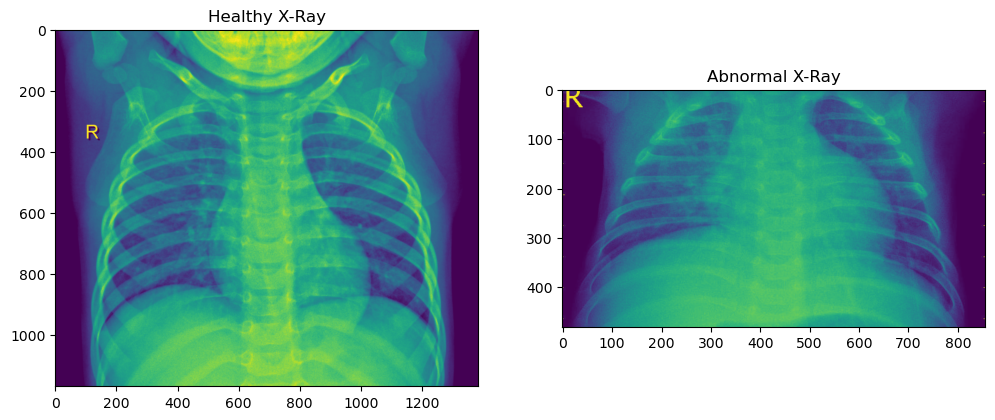

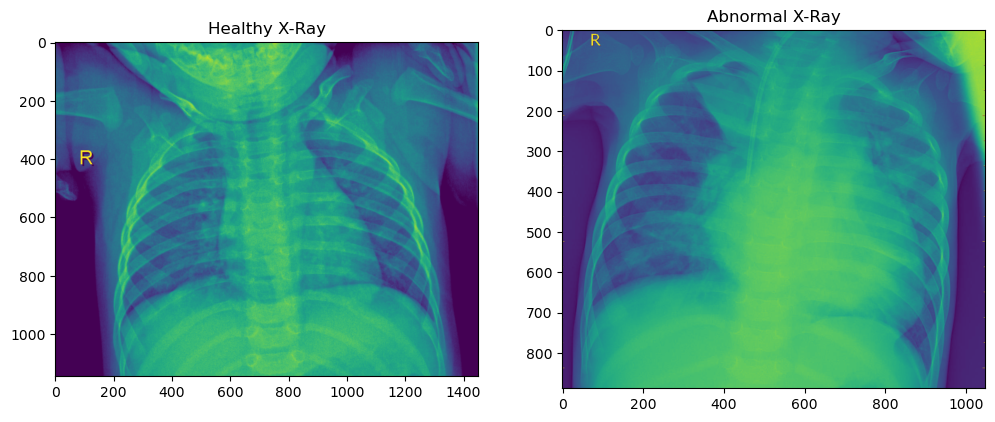

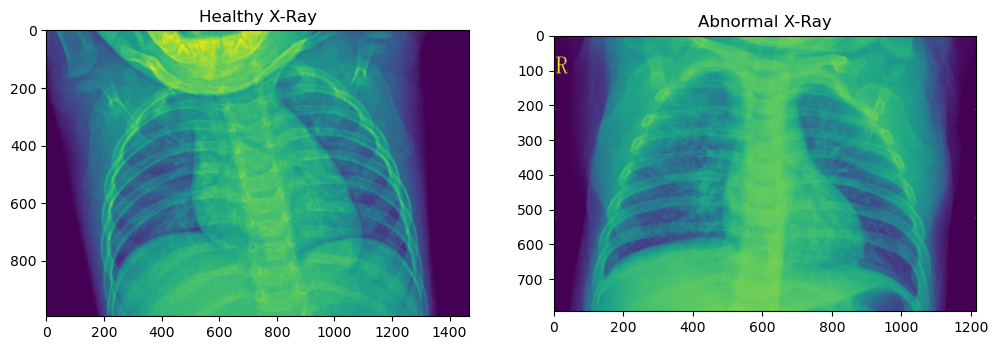

In [39]:
import matplotlib.image as mpimg

healthy_x_rays = train_df[train_df['binary_label'] == '0'][:10]
abnormal_x_rays = train_df[train_df['binary_label'] == '1'][:10]

raw_paths = "../../data/raw/train/"

for i in range(10):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Load the healthy X-ray image
    healthy_image_path = raw_paths + healthy_x_rays.iloc[i]['filename']
    healthy_img = mpimg.imread(healthy_image_path)
    ax[0].imshow(healthy_img)
    ax[0].set_title('Healthy X-Ray')

    # Load the abnormal X-ray image
    abnormal_image_path = raw_paths + abnormal_x_rays.iloc[i]['filename']
    abnormal_img = mpimg.imread(abnormal_image_path)
    ax[1].imshow(abnormal_img)
    ax[1].set_title('Abnormal X-Ray')

    plt.show()

In [48]:
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts

# Load ResNet50V2
resnet50 = ResNet50V2(include_top=False, weights='imagenet', pooling='max', input_shape=(224, 224, 3))

# # freeze deeper layers
# for layer in resnet50.layers:
#     layer.trainable = False

for layer in resnet50.layers:
    layer.trainable = True

# Define the model
model = Sequential([
    resnet50,
    Dense(256),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(128),
    Activation('relu'),
    Dense(1, activation="sigmoid")
])

# # Implement Cosine Annealing
initial_lr = 0.0001  # Start higher to encourage exploration
first_decay_steps = 5 * 326  # Assuming 62 steps per epoch and 5-epoch initial cycle

cosine_decay_restarts = CosineDecayRestarts(
    initial_learning_rate=initial_lr,
    first_decay_steps=first_decay_steps,
    t_mul=2.0,  # Double cycle length after each restart
    m_mul=0.8,  # Reduce LR after each restart
    alpha=1e-6  # Small floor LR to prevent zero updates
)

optimizer = Adam(learning_rate=cosine_decay_restarts)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', 'AUC']
)

# # Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# # Train the model
history = model.fit(
        train_generator,
        validation_data=test_generator,
        epochs=100,
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
)

Epoch 1/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - AUC: 0.9230 - accuracy: 0.8801 - loss: 0.2796
Epoch 1: val_loss improved from inf to 0.61808, saving model to best_model.keras
326/326 ━━━━━━━━━━━━━━━━━━━━ 97s 146ms/step - AUC: 0.9231 - accuracy: 0.8802 - loss: 0.2793 - val_AUC: 0.9271 - val_accuracy: 0.7837 - val_loss: 0.6181
Epoch 2/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - AUC: 0.9887 - accuracy: 0.9635 - loss: 0.1140
Epoch 2: val_loss improved from 0.61808 to 0.35891, saving model to best_model.keras
326/326 ━━━━━━━━━━━━━━━━━━━━ 44s 136ms/step - AUC: 0.9887 - accuracy: 0.9636 - loss: 0.1139 - val_AUC: 0.9437 - val_accuracy: 0.8814 - val_loss: 0.3589
Epoch 3/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - AUC: 0.9980 - accuracy: 0.9856 - loss: 0.0478
Epoch 3: val_loss did not improve from 0.35891
326/326 ━━━━━━━━━━━━━━━━━━━━ 42s 128ms/step - AUC: 0.9980 - accuracy: 0.9856 - loss: 0.0478 - val_AUC: 0.9370 - val_accuracy: 0.8654 - val_loss: 0.4230
Epoch 4/100
326/326 ━━

In [10]:
# create a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

X_test = []

for file in 

y_pred = model.predict()
y_pred = y_pred > 0.5
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# output precision, recall, f1-score
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))



NameError: name 'X_test' is not defined

In [49]:
# prompt: Save the .keras and .h5 file to my google drive

model.save('./best_model.h5')
model.save('./best_model.keras')
